In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
%matplotlib widget

### Constante

In [2]:
ua = 149597870.7 # km/ua
G = 6.67430e-11 # m³/kg/s² 
G = G*86400**2/10**9/ua**3
masses = [1.988e30, 1.898e27] # [Sun, Jupiter] in kg

### Repères


In [3]:
hms_to_rad = lambda x: 2*np.pi/86400* (x[0]*3600+x[1]*60+x[2])
# calcul position 1
a_hms1 = [3,34,9.55752]
a_rad1 = hms_to_rad(a_hms1)
r1 = 5.009363067
coord_Jup_Sun1 = np.array([r1*np.cos(a_rad1),r1*np.sin(a_rad1),0])
R1 = masses[1]*coord_Jup_Sun1/(masses[0]+masses[1])
coord_Jup_CM1 = coord_Jup_Sun1-R1
coord_Sun_CM1 = -R1
print(coord_Sun_CM1)
print(coord_Jup_CM1)

# calcul position 2
a_hms2 = [3,34,9.55777]
a_rad2 = hms_to_rad(a_hms2)
r2 = 5.009363070
coord_Jup_Sun2 = np.array([r2*np.cos(a_rad2),r2*np.sin(a_rad2),0])
R2 = masses[1]*coord_Jup_Sun2/(masses[0]+masses[1])
coord_Jup_CM2 = coord_Jup_Sun2-R2
coord_Sun_CM2 = -R2

# calcul vitesse (approx linéaire aval)
vit_Sun = (coord_Sun_CM2-coord_Sun_CM1)*86400
vit_Jup = (coord_Jup_CM2-coord_Jup_CM1)*86400
print(vit_Sun)
print(vit_Jup)

[-0.0028394  -0.00384282 -0.        ]
[2.97404437 4.02503808 0.        ]
[ 5.88936488e-06 -4.65896550e-06  0.00000000e+00]
[-0.00616863  0.00487989  0.        ]


### Méthode

In [10]:
def distance(x1,x2):
    return (np.sqrt((x1[0]-x2[0])**2+(x1[1]-x2[1])**2+(x1[2]-x2[2])**2))

def Heun(G, masses, pos_init, v_init, dt, tmax):
    t = np.arange(0,tmax+dt,dt)
    pos = np.zeros((len(pos_init),len(pos_init[0]),len(t)))
    vit = np.zeros((len(v_init),len(v_init[0]),len(t)))
    E = np.zeros(len(t))
    E[0] = 1/2*masses[0]*np.dot(v_init[0],v_init[0])+ 1/2*masses[1]*np.dot(v_init[1],v_init[1])\
           -G*masses[0]*masses[1]/(distance(pos_init[0],pos_init[1]))
    pos[0,:,0] = pos_init[0]
    pos[1,:,0] = pos_init[1]
    vit[0,:,0] = v_init[0]
    vit[1,:,0] = v_init[1]
    for i in range(len(t)-1):
        pos_0 = pos[0,:,i] - dt*vit[0,:,i]/masses[0]
        pos_1 = pos[1,:,i] - dt*vit[1,:,i]/masses[1]

        vit_0 = vit[0,:,i] - dt*G*masses[0]*masses[1]/(distance(pos[0,:,i],pos[1,:,i])**3)*(pos[0,:,i]-pos[1,:,i])
        vit_1 = vit[1,:,i] + dt*G*masses[0]*masses[1]/(distance(pos[0,:,i],pos[1,:,i])**3)*(pos[0,:,i]-pos[1,:,i])

        pos[0,:,i+1] = pos[0,:,i] - dt/2*(vit[0,:,i]/masses[0]+vit_0[0]/masses[0])
        pos[1,:,i+1] = pos[1,:,i] - dt/2*(vit[1,:,i]/masses[1]+vit_1[1]/masses[1])

        vit[0,:,i+1] = vit[0,:,i] + dt/2*(G*masses[0]*masses[1]/(distance(pos[0,:,i],pos[1,:,i])**3)*(pos[0,:,i]-pos[1,:,i])\
                                         +G*masses[0]*masses[1]/(distance(pos_0,pos_1)**3)*(pos_0-pos_1))
        vit[1,:,i+1] = vit[1,:,i] + dt/2*(-G*masses[0]*masses[1]/(distance(pos[0,:,i],pos[1,:,i])**3)*(pos[0,:,i]-pos[1,:,i])\
                                          -G*masses[0]*masses[1]/(distance(pos_0,pos_1)**3)*(pos_0-pos_1))
        
        E[i+1] = 1/2*masses[0]*np.dot(vit[0,:,i+1],vit[0,:,i+1])+ 1/2*masses[1]*np.dot(vit[1,:,i+1],vit[1,:,i+1])\
                 -G*masses[0]*masses[1]/(distance(pos[0,:,i+1],pos[1,:,i+1]))
    return {'t':t,'pos':pos,'vit':vit,'E':E}

def SV(G, masses, pos_init, v_init, dt, tmax):
    t = np.arange(0,tmax+dt,dt)
    pos = np.zeros((len(pos_init),len(pos_init[0]),len(t)))
    vit = np.zeros((len(v_init),len(v_init[0]),len(t)))
    E = np.zeros(len(t))
    E[0] = 1/2*masses[0]*np.dot(v_init[0],v_init[0])+ 1/2*masses[1]*np.dot(v_init[1],v_init[1])+G*masses[0]*masses[1]/(distance(pos_init[0],pos_init[1]))
    pos[0,:,0] = pos_init[0]
    pos[1,:,0] = pos_init[1]
    vit[0,:,0] = v_init[0]
    vit[1,:,0] = v_init[1]
    for i in range(len(t)-1):
        pos_0 = pos[0,:,i] - dt/2*vit[0,:,i]/masses[0]
        pos_1 = pos[1,:,i] - dt/2*vit[1,:,i]/masses[1]

        vit[0,:,i+1] = vit[0,:,i] + dt*G*masses[0]*masses[1]/(distance(pos_0,pos_1)**3)*(pos_0-pos_1)
        vit[1,:,i+1] = vit[1,:,i] - dt*G*masses[0]*masses[1]/(distance(pos_0,pos_1)**3)*(pos_0-pos_1)

        pos[0,:,i+1] = pos_0 -dt/2*vit[0,:,i+1]/masses[0]
        pos[1,:,i+1] = pos_1 -dt/2*vit[1,:,i+1]/masses[1]

        E[i+1] = 1/2*masses[0]*np.dot(vit[0,:,i+1],vit[0,:,i+1])+ 1/2*masses[1]*np.dot(vit[1,:,i+1],vit[1,:,i+1])-G*masses[0]*masses[1]/(distance(pos[0,:,i+1],pos[1,:,i+1]))
    return {'t':t,'pos':pos,'vit':vit,'E':E}



### Calculs

In [11]:
# Conditions initiales
pos_init = np.array([coord_Sun_CM1,coord_Jup_CM1])
vit_init = np.array([vit_Sun,vit_Jup])

dt = 10 # nbre de jours par dt
N_tmax = 20 # nbre d'années de la simu
tmax = (N_tmax*365+(N_tmax/4)) #jours

solHeun = Heun(G, masses, pos_init, vit_init,dt, tmax)
solSV = SV(G,masses,pos_init,vit_init,dt,tmax)

np.savetxt(fname="./jup_v.txt", X=solHeun['vit'][1,:,:],delimiter='\t')
np.savetxt(fname="./jup_p.txt", X=solHeun['pos'][1,:,:],delimiter='\t')


### Plot

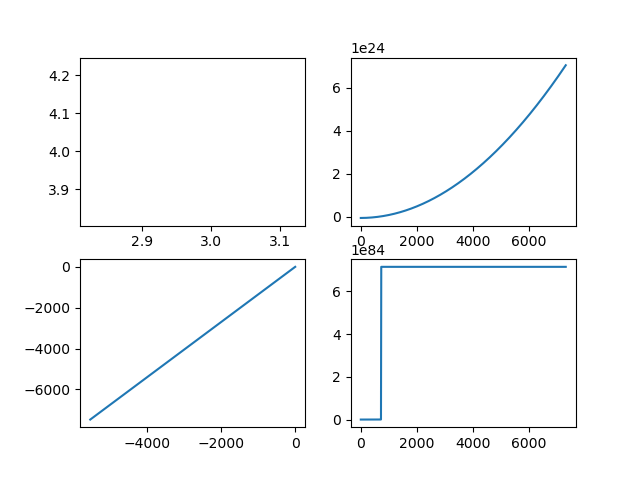

In [12]:

fig,ax = plt.subplots(2,2)

ax[0,0].plot(solHeun['pos'][1,0,:],solHeun['pos'][1,1,:])
ax[0,1].plot(solHeun['t'],solHeun['E'])
ax[1,0].plot(solSV['pos'][1,0,:],solSV['pos'][1,1,:])
ax[1,1].plot(solSV['t'],solSV['E'])


plt.show()